# Modern Portfolio Theory Notebook

### Objective:

1. We will construct an optimal portfolio using daily return data from 2016.
2. We will backtest the performance of that portolio in 2017, and we will compare it against the performance of the benchmark index (the DJIA).

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import quandl
import pandas_datareader.data as web
import datetime
from sqlalchemy import create_engine
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Modify notebook settings
%matplotlib inline
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
np.set_printoptions(suppress=True)

### Portfolio Constituents
Our portfolio will only contain constituents of the [Dow Jones Industrial Average](https://finance.yahoo.com/quote/%5EDJI/components/).

In [2]:
# Define a list of stock tickers of DJIA constituents.
stocks = ['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DD', 'DIS', 'GE', 'GS',
          'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT',
          'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'V', 'VZ', 'WMT', 'XOM']
stocks.sort()

### Retrieve stock data from Quandl and store it in a SQL database

In [3]:
# Create a variable for the project root directory
proj_root = os.path.join(os.pardir)

# Save the path to the folder that will contain the SQLite database 
# we will create to store stock data
raw_data_dir = os.path.join(proj_root, "data", "raw")

db_name = 'djia_constituents_2016.db'

#stock_db = os.path.join('sqlite:///', db_name)

sqlitedb_path = os.path.join(raw_data_dir, db_name)

sqlitedb_eng = os.path.join('sqlite:///', sqlitedb_path)

# Connect to a database engine
engine = create_engine(sqlitedb_eng)

In [4]:
# Set the start and end dates for the data we will retrieve
start = datetime.datetime(1998, 1, 1)
end = datetime.datetime(2018, 1, 1)

In [5]:
# Retrieve data for the Dow Jones Industrial Average index from FRED,
# and store it in the database
djia_table_name = 'DJIA_fred'

if djia_table_name in engine.table_names():
    #print(djia_table_name, 'already exists.')
    pass
else:
    df = web.DataReader("DJIA", "fred", start, end)
    df.to_sql(djia_table_name, engine)

In [6]:
# Retrieve stock data from Quandl and store it in the database
for stock in stocks:

    # Set the table name
    table_name = stock + '_table'
    
    if table_name in engine.table_names():
        #print(table_name, 'already exists.')
        pass        
    else:
        # Retrieve stock data from Quandl
        df = quandl.get('WIKI/{}'.format(stock), start_date=start, end_date=end)

        # Make column names contain only alphabetical characters and underscores.
        df = df.rename(columns={c: c.replace('. ', '_').replace('-', '_').\
                                replace(' ', '_') for c in df.columns}) 

        df.to_sql(table_name, engine)

## Create a Dataframe of price data
Create a Dataframe that contains Adj_Close that contains daily adjusted close of each stock in the DJIA, as well as the daily DJIA time series.

In [7]:
# Build a Dataframe called "prices_df"

# Include each price time series
sql_query = """SELECT Date, Adj_Close AS {s} FROM {s}_table""".format(s=stocks[0])
prices_df = pd.read_sql_query(sql=sql_query, con=engine, index_col='Date')

for s in stocks[1:]:
    sql_query = """SELECT Date, Adj_Close AS {s} FROM {s}_table""".format(s=s)
    temp_df = pd.read_sql_query(sql=sql_query, con=engine, index_col='Date')
    prices_df = pd.concat([prices_df, temp_df],axis=1)
    
# Include the DJIA index time series
sql_query = """SELECT * FROM {s}""".format(s=djia_table_name)
temp_df = pd.read_sql_query(sql=sql_query, con=engine, index_col='DATE')
prices_df = pd.concat([temp_df, prices_df],axis=1)

# Reformat the Date index
prices_df.index = pd.DatetimeIndex(prices_df.index, name='Date')

### Check for missing values in 2016 and 2017
For each price time series, we will calculate the proportion of missing values.

In [8]:
# Calculate the proportion of missing values by ticker and sort from largest to smallest.
(prices_df['2016':'2017'].isnull().sum(axis=0) \
    / len(prices_df['2016':'2017'])).sort_values(ascending=False)

TRV     0.669866
DD      0.193858
MMM     0.088292
INTC    0.038388
AAPL    0.038388
XOM     0.036468
AXP     0.036468
BA      0.036468
CAT     0.036468
CSCO    0.036468
CVX     0.036468
DIS     0.036468
GE      0.036468
GS      0.036468
HD      0.036468
IBM     0.036468
JPM     0.036468
JNJ     0.036468
WMT     0.036468
KO      0.036468
MCD     0.036468
MRK     0.036468
MSFT    0.036468
NKE     0.036468
PFE     0.036468
PG      0.036468
UNH     0.036468
UTX     0.036468
V       0.036468
VZ      0.036468
DJIA    0.034549
dtype: float64

All price data for Travelers Insurance (TRV) is missing in 2016 and 2017. 

Additionally, much of the price data for Du Pont (DD) and 3M (MMM) is missing in 2017.

We will exclude these three stocks (DD, MMM, and TRV) from our portfolio and any further analysis.

Next, we construct a Dataframe of the 2016 time series, excluding DD, MMM, TRV, and the benchmark index DJIA.  We will call the Dataframe "prices_2016".

In [9]:
# Create prices_2016
prices_2016 = prices_df['2016'].drop(['DJIA', 'DD', 'MMM', 'TRV'], axis=1)

In [10]:
# Number of observations (excluding missing observations)
len(prices_2016.dropna())

252

In [11]:
# Number of stocks
stocks_count = len(prices_2016.columns)
stocks_count

27

### Calculate the annualized mean of log returns for each stock

In [12]:
# Calculate daily log returns
log_returns = np.log(prices_2016/prices_2016.shift(1))
log_returns.dropna(inplace=True)

# Numerical optimization

We will use a numerical optimization method called Sequential Least SQuares Programming (SLSQP) to find optimal portfolio weights.  We are finding the weights that would have given use the portfolio with the highest Sharpe ratio (in 2016).

In [13]:
# Initialize the portfolio weights such that all 29 stocks have the same weight.
weights_initial = np.array([(1 / stocks_count) for i in range(stocks_count)])

Our portfolio will be long-only, and we will not use leverage.  Therefore, each of the portfolio weights will be constrained to the range [0, 1].

In [14]:
# Constrain weights to the range [0, 1].
weight_bounds = tuple((0, 1) for i in range(stocks_count))

Our portfolio will be fully invested. Therefore, the portfolio weights must sum to 1.

In [15]:
# Contraints
def check_sum(weights):
    '''
    Arguments: An array of portfolio weights.
    Returns 0 if sum of weights is 1.0.
    '''
    return np.sum(weights) - 1

In [16]:
def calculate_rvs(log_returns_df, weights=None):
    """
    Arguments: (1) A dataframe of daily log returns
    and (2) an array of weights.
    
    Returns a dictionary containing
    annualized returns ("r"),
    annualized volatility ("v"), and the 
    annualized sharpe ratio ("s").
    """
    
    if len(log_returns_df.columns) == 1:        
        returns = np.array(252 * log_returns_df.mean().values)
        volatility = np.array(np.sqrt(252) * \
                              log_returns_df.std().values)
        
    else:
        weights = np.array(weights)
        returns = np.array(252 * np.sum(weights * \
                                        log_returns_df.mean())).reshape(1,)
        volatility = np.array(np.sqrt(np.dot(weights.T,
                                             np.dot(252 * \
                                                    log_returns_df.cov(),
                                                    weights)))).reshape(1,)
    
    sharpe_ratio = returns / volatility

    return {'r': returns,'v': volatility,'s': sharpe_ratio}

In [17]:
def negative_sr(weights, log_returns_df):
    return calculate_rvs(log_returns_df, weights)['s'] * -1

In [18]:
# By convention of minimize function it should be a function that returns zero for conditions
constraints = ({'type':'eq','fun': check_sum})

In [19]:
# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(negative_sr,
                       weights_initial, 
                       args=(log_returns),
                       method='SLSQP',
                       bounds=weight_bounds,
                       constraints=constraints)

In [20]:
#opt_results.x
optimal_weights = opt_results.x
optimal_weights

array([ 0.        ,  0.        ,  0.        ,  0.06140957,  0.        ,
        0.18320733,  0.        ,  0.        ,  0.        ,  0.        ,
        0.10937602,  0.        ,  0.09756229,  0.04600496,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.38082276,  0.        ,  0.        ,  0.11188382,
        0.00973326,  0.        ])

In [21]:
calculate_rvs(log_returns, optimal_weights)

{'r': array([ 0.27488626]),
 's': array([ 2.04948349]),
 'v': array([ 0.13412465])}

# Backtest portfolio performance in 2017

### Portfolio performance

In [22]:
# Create prices_2017
prices_2017 = prices_df['2017'].drop(['DJIA', 'DD', 'MMM', 'TRV'], axis=1)

In [23]:
# Normalize prices
prices_2017_normalized = prices_2017.dropna() /\
prices_2017.dropna().iloc[0]

In [24]:
# Weigh the portfolio constituents with the optimal weights 
# determined above.
portfolio_2017_array = np.dot(prices_2017_normalized,
                              optimal_weights)

In [25]:
# Create a Dataframe of the normalized portfolio time series.
portfolio_2017_df = pd.DataFrame(data=portfolio_2017_array, 
                                 index=prices_2017_normalized.index,
                                 columns=['Portfolio'])

In [26]:
# Calculate daily log returns of the portfolio.
log_returns_2017_portfolio = np.log(portfolio_2017_df.dropna() /\
                                    portfolio_2017_df.dropna().shift(1))
log_returns_2017_portfolio.dropna(inplace=True)

In [27]:
rvs_2017_portfolio = calculate_rvs(log_returns_2017_portfolio)

rvs_2017_portfolio

{'r': array([ 0.21905649]),
 's': array([ 2.6085937]),
 'v': array([ 0.08397493])}

### Benchmark performance

In [28]:
# Create benchmark_2017
benchmark_2017 = prices_df['2017'][['DJIA']]

In [29]:
# Normalize prices
benchmark_2017_df = benchmark_2017.dropna() /\
benchmark_2017.dropna().iloc[0]

In [30]:
# Calculate daily log returns of the benchmark.
log_returns_2017_benchmark = np.log(benchmark_2017_df.dropna() /\
                                    benchmark_2017_df.dropna().shift(1))
log_returns_2017_benchmark.dropna(inplace=True)

In [31]:
rvs_2017_benchmark = calculate_rvs(log_returns_2017_benchmark)

rvs_2017_benchmark

{'r': array([ 0.21952058]),
 's': array([ 3.3179173]),
 'v': array([ 0.06616216])}

### Plot the 2017 time series

In [32]:
plot_df_2017 = pd.concat([portfolio_2017_df,
                          benchmark_2017_df],
                         axis=1)

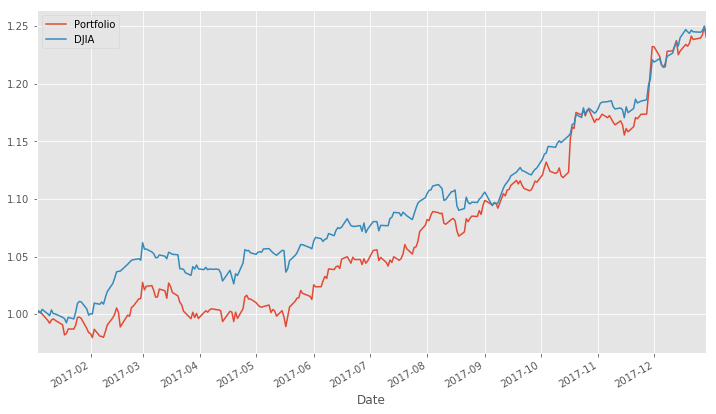

In [33]:
plt.style.use('ggplot')

plot_df_2017.interpolate(method='linear',
                         axis=0).plot(figsize=(12,7))

In [34]:
# Annual returns
(plot_df_2017.iloc[-1] / plot_df_2017.iloc[0]) - 1

Portfolio    0.240580
DJIA         0.243311
dtype: float64

In [35]:
backtest_results_p = pd.DataFrame(data=[((plot_df_2017.iloc[-1] /\
                                          plot_df_2017.iloc[0]) - 1)[0],
                                        rvs_2017_portfolio['s'][0],
                                        rvs_2017_portfolio['r'][0],
                                        rvs_2017_portfolio['v'][0]],
                                  index=['Annual Returns',
                                         'Sharpe Ratio',
                                         'Mean Returns',
                                         'Volatility'],
                                  columns=['Portfolio'])

In [36]:
backtest_results_b = pd.DataFrame(data=[((plot_df_2017.iloc[-1] /\
                                          plot_df_2017.iloc[0]) - 1)[1],
                                        rvs_2017_benchmark['s'][0],
                                        rvs_2017_benchmark['r'][0],
                                        rvs_2017_benchmark['v'][0]],
                                  index=['Annual Returns',
                                         'Sharpe Ratio',
                                         'Mean Returns',
                                         'Volatility'],
                                  columns=['Benchmark'])

In [37]:
backtest_results_df = pd.concat([backtest_results_p,
                                 backtest_results_b],axis=1)

In [38]:
backtest_results_df

,Portfolio,Benchmark
Annual Returns,0.240580,0.243311
Sharpe Ratio,2.608594,3.317917
Mean Returns,0.219056,0.219521
Volatility,0.083975,0.066162


## Visualize the efficient frontier and where our portfolio lies

In [39]:
#  ...